In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [176]:
path = "./public_train/prescription/label/*.json"

In [177]:
import json
import glob
id = []
drugname_text = []
mapping = []
files = glob.glob(path)
for file in sorted(files):
    with open(file, encoding='utf-8') as json_file:
        data = json.load(json_file)
        for i in data:
            if i["label"] == "drugname":
                id.append(i["id"])
                drugname_text.append(i["text"])
                mapping.append(i["mapping"])

In [178]:
print(len(id))
print(len(drugname_text))
print(len(mapping))

2844
2844
2844


In [179]:
data_write = [[id[i], drugname_text[i], mapping[i]] for i in range(len(id))]

In [180]:
print(drugname_text[0])

1) RENAPRIL 5MG 5mg


In [181]:
data_write[:6]

[[23, '1) RENAPRIL 5MG 5mg', 47],
 [27, '2) NOVOXIM-500 0,5g', 10],
 [30, '3) HOẠT HUYẾT DƯỠNG NÃO 150mg+20mg', 64],
 [25, '1) GLUCOFAST 850 850mg', 55],
 [30, "2) DIAMICRON MR TAB 30MG 60'S 30mg", 37],
 [34, '3) ENALAPRIL 5mg', 46]]

In [182]:
import csv
data_write = [[id[i], drugname_text[i], mapping[i]] for i in range(len(id))]
field_names = ["id", "drugname", "mapping"]
fileName = "ID_DRUGNAME_MAPPING.csv"
with open(fileName, "w", encoding='UTF8') as csvFileWrite:
    wrtier_csv = csv.writer(csvFileWrite)
    wrtier_csv.writerow(field_names)
    wrtier_csv.writerows(data_write)

In [183]:
# Create mapping dictionary
mapping_dict = {}
for i in mapping:
    if i not in mapping_dict:
        mapping_dict[i] = 1
    else:
        mapping_dict[i] += 1
mapping_dict[106]

10

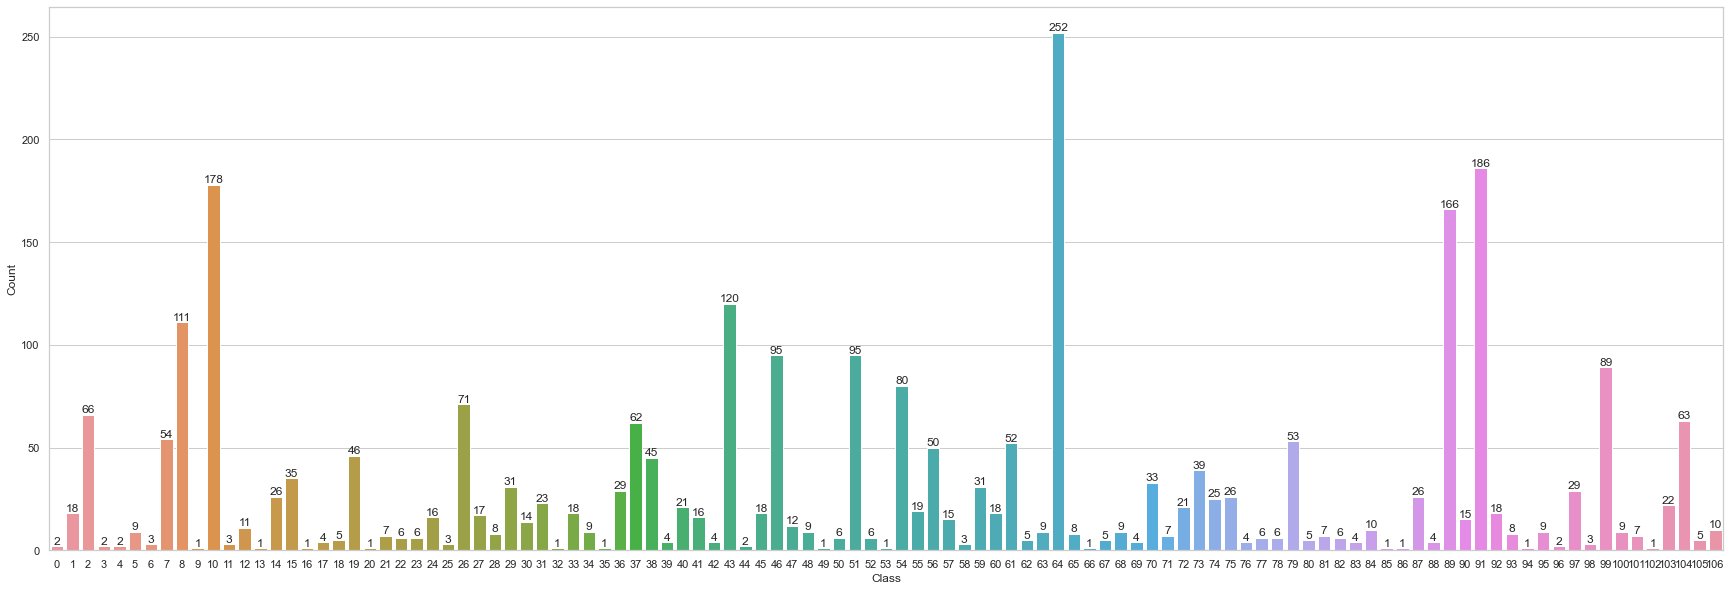

In [184]:
import collections
od = collections.OrderedDict(sorted(mapping_dict.items()))
classes = list(od.keys())
number_values = list(od.values())

plt.figure(figsize=(30,10))
sns.set(style="whitegrid")
ax = sns.barplot(x=classes, y=number_values)
ax.set(xlabel='Class', ylabel='Count')
ax.bar_label(ax.containers[0])
plt.show()


* Xây dựng bộ phân loại văn bản với đầu vào là tên thuốc, đầu ra là số mapping của thuốc đó <br>
Sử dụng Navie Bayes

In [185]:
df = pd.DataFrame({"id": id, "drugname": drugname_text[:], "mapping":mapping})
df

,id,drugname,mapping
0,23,1) RENAPRIL 5MG 5mg,47
1,27,"2) NOVOXIM-500 0,5g",10
2,30,3) HOẠT HUYẾT DƯỠNG NÃO 150mg+20mg,64
3,25,1) GLUCOFAST 850 850mg,55
4,30,2) DIAMICRON MR TAB 30MG 60'S 30mg,37
...,...,...,...
2839,24,1) AMCARDIA-5 5mg,8
2840,26,1) LAZIBET MR 60 60mg,38
2841,30,2) ENALAPRIL 5mg,46
2842,25,"1) CEFADROXIL 500MG 0,5g",43


In [186]:
a = df.sort_values(by="mapping").reset_index().drop(["index"], axis=1)
a

,id,drugname,mapping
0,23,2) PARACETAMOL 500MG 500mg,0
1,32,3) PARACETAMOL 500MG 500mg,0
2,27,2) TYDOL PM 500mg + 25mg,1
3,23,1) TROYSAR AM 5mg +50mg,1
4,23,1) TROYSAR AM 5mg +50mg,1
...,...,...,...
2839,28,3) C1000 FLOODE 1g,106
2840,39,4) C1000 FLOODE 1g,106
2841,28,3) C1000 FLOODE 1g,106
2842,38,4) C1000 FLOODE 1g,106


1. Cần tạo 1 thư mục có cấu trúc như sau: data/tên mapping/chứa các file

In [187]:
new_data = a[["drugname", "mapping"]].copy().reset_index().drop(["index"], axis=1)
new_data

,drugname,mapping
0,2) PARACETAMOL 500MG 500mg,0
1,3) PARACETAMOL 500MG 500mg,0
2,2) TYDOL PM 500mg + 25mg,1
3,1) TROYSAR AM 5mg +50mg,1
4,1) TROYSAR AM 5mg +50mg,1
...,...,...
2839,3) C1000 FLOODE 1g,106
2840,4) C1000 FLOODE 1g,106
2841,3) C1000 FLOODE 1g,106
2842,4) C1000 FLOODE 1g,106


In [188]:
# Create directories
import os
dirName = "data_gen/"
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists") 
for i in od.keys():
    sub_dir = dirName + str(i)
    try:
        os.mkdir(sub_dir)
    except FileExistsError:
        None



Directory  data_gen/  already exists


In [189]:
# Write content to directories
np.random.seed(42)
for i in range(len(new_data)):
    sub_dir = dirName + str(new_data["mapping"].iloc[i]) + "/"
    random_name = str(np.random.random()) + ".txt"
    # print(sub_dir + random_name)
    with open(sub_dir + random_name, 'w', encoding='UTF8') as f:
        f.write(str(new_data["drugname"].iloc[i]))



2. Chuẩn bị dữ liệu để train (sử dụng tf-idf)

In [190]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_files
from pyvi import ViTokenizer


from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

## Load dữ liệu từ thư mục có sẵn

In [191]:
path = "./data_gen/"


data_train = load_files(container_path=path, encoding="utf-8")
print("Tong so file: {}" .format( len(data_train.filenames)))
print("Danh sách nhãn và id tương ứng: ", [(idx, name) for idx, name in enumerate(data_train.target_names)] )
a = [name for idx, name in enumerate(data_train.target_names)]


Tong so file: 2844
Danh sách nhãn và id tương ứng:  [(0, '0'), (1, '1'), (2, '10'), (3, '100'), (4, '101'), (5, '102'), (6, '103'), (7, '104'), (8, '105'), (9, '106'), (10, '11'), (11, '12'), (12, '13'), (13, '14'), (14, '15'), (15, '16'), (16, '17'), (17, '18'), (18, '19'), (19, '2'), (20, '20'), (21, '21'), (22, '22'), (23, '23'), (24, '24'), (25, '25'), (26, '26'), (27, '27'), (28, '28'), (29, '29'), (30, '3'), (31, '30'), (32, '31'), (33, '32'), (34, '33'), (35, '34'), (36, '35'), (37, '36'), (38, '37'), (39, '38'), (40, '39'), (41, '4'), (42, '40'), (43, '41'), (44, '42'), (45, '43'), (46, '44'), (47, '45'), (48, '46'), (49, '47'), (50, '48'), (51, '49'), (52, '5'), (53, '50'), (54, '51'), (55, '52'), (56, '53'), (57, '54'), (58, '55'), (59, '56'), (60, '57'), (61, '58'), (62, '59'), (63, '6'), (64, '60'), (65, '61'), (66, '62'), (67, '63'), (68, '64'), (69, '65'), (70, '66'), (71, '67'), (72, '68'), (73, '69'), (74, '7'), (75, '70'), (76, '71'), (77, '72'), (78, '73'), (79, '74')

In [192]:
# load dữ liệu các stopwords 
with open("C:\\Users\\longln3\\Downloads\\vinbigdata\\Machine Learning\\Lesson 7\\L7_SVM\\data\\vietnamese-stopwords.txt",encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print("Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại): ", stopwords[:10])

# Transforming data 
# Chuyển hoá dữ liệu text về dạng vector tfidf 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
print("10 từ đầu tiên trong từ điển:")
i = 0
for k,v in module_count_vector.vocabulary_.items():
    i+=1
    print(i, ": ", (k, v))
    if i > 10:
        break 

Danh sách 10 từ dừng đầu tiên (từ không mang ý nghĩa phân loại):  ['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']
10 từ đầu tiên trong từ điển:
1 :  ('mezafen', 168)
2 :  ('60mg', 57)
3 :  ('đinh', 228)
4 :  ('lăng', 156)
5 :  ('bạch', 90)
6 :  ('hoạt', 137)
7 :  ('huyết', 138)
8 :  ('dưỡng', 117)
9 :  ('não', 178)
10 :  ('150mg', 14)
11 :  ('20mg', 26)


In [193]:
print(data_preprocessed)

  (0, 168)	0.8002260902354524
  (0, 57)	0.5996984279673256
  (1, 228)	0.40497609121238676
  (1, 178)	0.2925789638786182
  (1, 156)	0.40497609121238676
  (1, 138)	0.2925789638786182
  (1, 137)	0.29526671690210304
  (1, 117)	0.2945868937573231
  (1, 90)	0.40497609121238676
  (1, 26)	0.27716927940603325
  (1, 14)	0.29324309864043446
  (2, 207)	0.7864486986147644
  (2, 33)	0.61765560342892
  (3, 120)	0.765826003448813
  (3, 51)	0.3752905377648014
  (3, 50)	0.5221757795089932
  (4, 184)	0.8719145701769335
  (4, 51)	0.4896580258845691
  (5, 88)	0.8061802369025705
  (5, 53)	0.5916700310373301
  (6, 120)	0.5990655321171798
  (6, 73)	0.6229676840700084
  (6, 51)	0.2935701121300986
  (6, 50)	0.408470735913274
  (7, 160)	0.5649833980006344
  :	:
  (2838, 138)	0.4105050148913167
  (2838, 137)	0.41427608605891963
  (2838, 117)	0.4133222553170516
  (2838, 26)	0.38888434650822223
  (2838, 14)	0.41143683393488373
  (2839, 125)	0.5773502691896257
  (2839, 113)	0.5773502691896257
  (2839, 60)	0.57735026

In [194]:
from sklearn.model_selection import ShuffleSplit

# chia dữ liệu thành 2 phần sử dụng hàm train_test_split.
test_size = 0.
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split( data_preprocessed, data_train.target)
X_train = data_preprocessed.copy()
y_train = data_train.target
# hiển thị một số thông tin về dữ liệu 
print("Dữ liệu training: ", X_train.shape, y_train.shape)
print(X_train)

Dữ liệu training:  (2844, 230) (2844,)
  (0, 168)	0.8002260902354524
  (0, 57)	0.5996984279673256
  (1, 228)	0.40497609121238676
  (1, 178)	0.2925789638786182
  (1, 156)	0.40497609121238676
  (1, 138)	0.2925789638786182
  (1, 137)	0.29526671690210304
  (1, 117)	0.2945868937573231
  (1, 90)	0.40497609121238676
  (1, 26)	0.27716927940603325
  (1, 14)	0.29324309864043446
  (2, 207)	0.7864486986147644
  (2, 33)	0.61765560342892
  (3, 120)	0.765826003448813
  (3, 51)	0.3752905377648014
  (3, 50)	0.5221757795089932
  (4, 184)	0.8719145701769335
  (4, 51)	0.4896580258845691
  (5, 88)	0.8061802369025705
  (5, 53)	0.5916700310373301
  (6, 120)	0.5990655321171798
  (6, 73)	0.6229676840700084
  (6, 51)	0.2935701121300986
  (6, 50)	0.408470735913274
  (7, 160)	0.5649833980006344
  :	:
  (2838, 138)	0.4105050148913167
  (2838, 137)	0.41427608605891963
  (2838, 117)	0.4133222553170516
  (2838, 26)	0.38888434650822223
  (2838, 14)	0.41143683393488373
  (2839, 125)	0.5773502691896257
  (2839, 113)	0.5

In [195]:
print("- Training ...")
print("- Train size = {}".format(X_train.shape))
model = svm.SVC(kernel='linear', C=1)
model.fit(X_train, y_train)
print("- model - train complete")

- Training ...
- Train size = (2844, 230)
- model - train complete


In [196]:
from sklearn.metrics import accuracy_score, f1_score
print("- Testing ...")
y_train_pred = model.predict(X_train)
print("- Train Acc = {}".format(accuracy_score(y_train, y_train_pred)))
print("- Train F1 = {}".format(f1_score(y_train, y_train_pred, average = 'macro')))

- Testing ...
- Train Acc = 0.840014064697609
- Train F1 = 0.6830561747732146


In [197]:
list_test_mapping = []

In [200]:
# Tiền xử lý dữ liệu sử dụng module model_rf_preprocess. 
new_doc = "2) SETBLOOD 115mg+100mg+50mcg"
# Trước hết, cần thực hiện tách từ sử dụng pyvi
tokenized_new_doc = ViTokenizer.tokenize(new_doc)
# Cần đưa văn bản ở dạng mảng/vector
tokenized_new_doc = [tokenized_new_doc]
# print(tokenized_new_doc)
# Rồi sử dụng module model_rf_preprocess
input_data_preprocessed = model_rf_preprocess.transform(tokenized_new_doc)
# print(input_data_preprocessed)
# code 
label = int(model.predict(input_data_preprocessed))
print(a[label])

104


In [199]:
# # code
# # Có thể tham khảo giá trị các tham số như sau
# params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
#           'gamma': [0.0001, 0.001, 0.01, 0.1],
#           'kernel':['linear','rbf', 'poly'] }

# n_jobs = 3
# gcv = GridSearchCV(estimator=model, cv=5, param_grid=params_grid,
#                             n_jobs=n_jobs, scoring='accuracy')
# gcv.fit(X_train, y_train)
# print(gcv.best_estimator_)